# Part 1 Find a social media dataset that contains medical questions.
Data must contain medical questions from patients or HCPs.

[This GitHub library](https://github.com/abachaa/MedQuAD) has lots of medical questions from many different sources in XML format. To read the data we'll need the ```xmltodict``` package.

In [1]:
import os
if not os.path.exists('./data'):
  os.makedirs('./data')

In [2]:
%%capture
!wget https://github.com/abachaa/MedQuAD/archive/master.zip -P ./data/
!unzip ./data/master.zip -d ./data/
!pip install xmltodict

In [3]:
import xmltodict # needed for extracting the data
import json # needed for extracting the data
import pandas as pd # used to manipulate and analyze the data
import os

# Part 2 Clean the data.
Provide an example of the raw data next to the cleaned data.

Since the raw data is in XML we need to parse the data.

In [4]:
with open('./data/MedQuAD-master/10_MPlus_ADAM_QA/0000001.xml') as file:
    contents = file.read()
    print(contents)

<?xml version="1.0" encoding="UTF-8"?>
<Document id="0000001" source="ADAM" url="https://www.nlm.nih.gov/medlineplus/ency/patientinstructions/000823.htm">
 <!--Answers from the A.D.A.M. medical encyclopedia were removed to comply with the MedlinePlus copyright-->
<Focus>A guide to clinical trials for cancer</Focus>
<FocusAnnotations>
	<Category>Disease</Category>
	<UMLS>
		<CUIs>
			<CUI>C0006826</CUI>
		</CUIs>
		<SemanticTypes>
			<SemanticType>T191</SemanticType>
		</SemanticTypes>
		<SemanticGroup>Disorders</SemanticGroup>
	</UMLS>
	<Synonyms>
		<Synonym>Intervention study</Synonym>
	</Synonyms>
</FocusAnnotations>
<QAPairs>
	<QAPair pid="1">
			<Question qid="0000001-1" qtype="information">What is (are) A guide to clinical trials for cancer ?</Question>
			<Answer></Answer>
	</QAPair>
	<QAPair pid="2">
			<Question qid="0000001-2" qtype="research">what research (or clinical trials) is being done for A guide to clinical trials for cancer ?</Question>
			<Answer></Answer>
	</QAPair>

After looking through the XML files, I created these functions to extract the questions. It's not perfect but it works with few exceptions. There are still 10 files that we can't read questions from but we have more than enough data points to work with here.

In [5]:
def read_questions_from_xml(filename):
    # Takes the name of an xml file, reads in the necessary data if it's there,
    # and returns a pandas dataframe of the questions in that file
    try:
        data = []
        
        with open(filename, encoding="utf8") as xml_file:
            data_dict = xmltodict.parse(xml_file.read())
        xml_file.close()
        try:
            source = data_dict['Document']['@source']
            root_name = 'Document'
        except:
            try:
                source = data_dict['DiseaseFile']['@source']
                root_name = 'DiseaseFile'
            except:
                source = data_dict['doc']['@corpus']
                root_name = 'doc'
        url = data_dict[root_name]['@url']
        try:
            focus = data_dict[root_name]['Focus']
        except:
            focus = data_dict[root_name]['doctitle-focus']
        
        try:
            a = data_dict[root_name]['FocusAnnotations']
            try:
                sgroup = data_dict[root_name]['FocusAnnotations']['UMLS']['SemanticGroup']
            except:
                sgroup = None
            try:
                category = data_dict[root_name]['FocusAnnotations']['Category']
            except Exception as e:
                category = None
            try:
                synonyms = data_dict[root_name]['FocusAnnotations']['Synonyms']['Synonym']
            except Exception as e:
                synonyms = None
        except:
            try:
                sgroup = data_dict[root_name]['UMLS']['SemanticGroup']
            except:
                sgroup = data_dict[root_name]['umls']['semanticGroup']
            try:
                category = data_dict[root_name]['Category']
            except Exception as e:
                category = None
            try:
                synonyms = data_dict[root_name]['Synonyms']['Synonym']
            except Exception as e:
                synonyms = None
        # This conditional concatenates a list of synonyms into a single string, comma delimited
        # if isinstance(synonyms, list):
        #     synonyms = ', '.join(synonyms)
            
        try:
            a = data_dict[root_name]['QAPairs']['QAPair'][0]
            for elem in data_dict[root_name]['QAPairs']['QAPair']:
                qtype = elem['Question']['@qtype']
                question = elem['Question']['#text']
                data.append({'source': source,
                             'url': url,
                             'focus': focus,
                             'category': category,
                             'semantic_group': sgroup,
                             'question_type': qtype,
                             'question': question,
                             'synonym': synonyms})
        except:
            qid = data_dict[root_name]['QAPairs']['QAPair']['Question']['@qid']
            qtype = data_dict[root_name]['QAPairs']['QAPair']['Question']['@qtype']
            question = data_dict[root_name]['QAPairs']['QAPair']['Question']['#text']
            data.append({'source': source,
                         'url': url,
                         'focus': focus,
                         'category': category,
                         'semantic_group': sgroup,
                         'question_type': qtype,
                         'question': question,
                         'synonym': synonyms})
        
        df = pd.DataFrame(data)
        return df
    except:
        print(f"Couldn't read questions from file: {filename}")
        return False

def load_input_data(cdir, verbose=False):
    # takes in a starting directory, cdir, and walks to each file in it and all
    # subdirectories. Calls read_questions_from_xml to get a dataframe of that
    # file's questions, and concatenates it with the main dataframe. Returns
    # complete dataframe of all questions in all files.
    total_files = 0
    counter = 0
    all_data = pd.DataFrame()
    for subdir, dirs, files in os.walk(cdir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".xml"):
                total_files += 1
                data = read_questions_from_xml(filepath)
                if isinstance(data, pd.DataFrame):
                    counter +=1
                    all_data = pd.concat([all_data, data], ignore_index=True)
                    if (verbose):
                        print(f"Loaded file {filepath}")
                        
    print(f"{counter} XML files read out of {total_files} in folder {cdir}")
    return all_data

We can now extract the questions from the files into ```med_qa_df```.

In [6]:
med_qa_df = load_input_data('./data/MedQuAD-master')

Couldn't read questions from file: ./data/MedQuAD-master/5_NIDDK_QA/0000056.xml
Couldn't read questions from file: ./data/MedQuAD-master/5_NIDDK_QA/0000177.xml
Couldn't read questions from file: ./data/MedQuAD-master/5_NIDDK_QA/0000064.xml
Couldn't read questions from file: ./data/MedQuAD-master/5_NIDDK_QA/0000065.xml
Couldn't read questions from file: ./data/MedQuAD-master/5_NIDDK_QA/0000077.xml
Couldn't read questions from file: ./data/MedQuAD-master/5_NIDDK_QA/0000175.xml
Couldn't read questions from file: ./data/MedQuAD-master/6_NINDS_QA/0000018.xml
Couldn't read questions from file: ./data/MedQuAD-master/6_NINDS_QA/0000182.xml
Couldn't read questions from file: ./data/MedQuAD-master/6_NINDS_QA/0000244.xml
Couldn't read questions from file: ./data/MedQuAD-master/6_NINDS_QA/0000007.xml
11264 XML files read out of 11274 in folder ./data/MedQuAD-master


We now have medical questions, with their sources, categories, question types, and synonyms.

In [7]:
print(f'This dataset has {len(med_qa_df)} records.')
med_qa_df.head(5)

This dataset has 47441 records.


,source,url,focus,category,semantic_group,question_type,question,synonym
0,NHLBI,http://www.nhlbi.nih.gov/health/health-topics/...,Endocarditis,None,Disorders,information,What is (are) Endocarditis ?,None
1,NHLBI,http://www.nhlbi.nih.gov/health/health-topics/...,Endocarditis,None,Disorders,causes,What causes Endocarditis ?,None
2,NHLBI,http://www.nhlbi.nih.gov/health/health-topics/...,Endocarditis,None,Disorders,susceptibility,Who is at risk for Endocarditis? ?,None
3,NHLBI,http://www.nhlbi.nih.gov/health/health-topics/...,Endocarditis,None,Disorders,symptoms,What are the symptoms of Endocarditis ?,None
4,NHLBI,http://www.nhlbi.nih.gov/health/health-topics/...,Endocarditis,None,Disorders,exams and tests,How to diagnose Endocarditis ?,None


In [8]:
med_qa_df.describe()

,source,url,focus,category,semantic_group,question_type,question,synonym
count,47441,47441,47427,32010,31417,47441,47441,24669
unique,12,11254,10537,3,1,39,44603,7142
top,ADAM,http://nihseniorhealth.gov/breastcancer/toc.html,Breast Cancer,Disease,Disorders,information,What causes Causes of Diabetes ?,HLHS
freq,17348,28,53,16256,31417,9214,20,12


Since the data is already cleaned and structured, there's not much for us to do in terms of preprocessing. However, we can see there are a lot of missing values in the `focus`, `category`, `semantic_group`, and `synonym` columns. Those columns may be useful for analysis so we will keep them in. There are also nearly 3,000 duplicates in the `question` column. Let's try to clean this up.

In [9]:
med_qa_cleaned_df = med_qa_df.drop_duplicates(subset='question',ignore_index=True)

med_qa_cleaned_df = med_qa_cleaned_df[(med_qa_cleaned_df['focus'].notna()) &
                                      (med_qa_cleaned_df['category'].notna()) &
                                      (med_qa_cleaned_df['semantic_group'].notna()) &
                                      (med_qa_cleaned_df['synonym'].notna())]

med_qa_cleaned_df = med_qa_cleaned_df[['question','question_type','focus','category','semantic_group','synonym']]

med_qa_cleaned_df.reset_index(drop=True, inplace=True)
med_qa_cleaned_df.describe()

,question,question_type,focus,category,semantic_group,synonym
count,12340,12340,12340,12340,12340,12340
unique,12340,14,2221,1,1,2209
top,What are the symptoms of Malocclusion of teeth ?,information,Osteonecrosis,Disease,Disorders,Trisomy 21
freq,1,2197,10,12340,12340,11


Since the `category` and `semantic_group` only have one unique value, they don't provide any additional information and we can remove them. Also, since those columns were used in filtering the data, we will go back and filter again.

In [10]:
med_qa_cleaned_2_df = med_qa_df.drop_duplicates(subset='question',ignore_index=True)
med_qa_cleaned_2_df = med_qa_cleaned_2_df[(med_qa_cleaned_2_df['focus'].notna()) &
                                          (med_qa_cleaned_2_df['synonym'].notna())]
med_qa_cleaned_2_df = med_qa_cleaned_2_df[['question','question_type','focus','synonym']]
med_qa_cleaned_2_df.reset_index(drop=True, inplace=True)
med_qa_cleaned_2_df.describe()

,question,question_type,focus,synonym
count,23319,23319,23319,23319
unique,23319,17,6761,6922
top,Do I need to see a doctor for Ptosis - infants...,information,Treacher Collins syndrome,Malignant mesothelioma
freq,1,5562,13,11


Now we have 23,319 questions for analysis. Even though this is roughly half the size of the original dataset, we think this amount of data is sufficient for our analysis. However, given that the `focus` and `synonym` columns were derived from something that appears in the original dataset per file and not per question, we have less diversity in the cleaned dataset. This is obvious from the `question_type` going from 39 unique values to 17 unique values.

Below are the question types that we were able to preserve.

In [11]:
set(med_qa_cleaned_2_df['question_type'])

{'causes',
 'complications',
 'considerations',
 'exams and tests',
 'frequency',
 'genetic changes',
 'information',
 'inheritance',
 'outlook',
 'prevention',
 'research',
 'stages',
 'support groups',
 'susceptibility',
 'symptoms',
 'treatment',
 'when to contact a medical professional'}

And below are the question types we cleaned out.

In [12]:
set(med_qa_df['question_type']) - set(med_qa_cleaned_2_df['question_type'])

{'brand names',
 'brand names of combination products',
 'contraindication',
 'dietary',
 'dose',
 'emergency or overdose',
 'forget a dose',
 'how can i learn more',
 'how does it work',
 'how effective is it',
 'important warning',
 'indication',
 'interactions with foods',
 'interactions with herbs and supplements',
 'interactions with medications',
 'other information',
 'precautions',
 'severe reaction',
 'side effects',
 'storage and disposal',
 'usage',
 'why get vaccinated'}

We still think that with this cleaned dataset, we have sufficient diversity in the types of questions for our analysis.

In [13]:
med_qa_cleaned_2_df['question_type'].value_counts()

information                               5562
symptoms                                  3322
treatment                                 2599
causes                                    1736
outlook                                   1451
when to contact a medical professional    1420
exams and tests                           1370
inheritance                               1369
genetic changes                           1085
frequency                                 1085
complications                              872
prevention                                 848
considerations                             288
support groups                             197
susceptibility                             113
research                                     1
stages                                       1
Name: question_type, dtype: int64

In [14]:
med_qa_cleaned_2_df.head(10)

,question,question_type,focus,synonym
0,Do you have information about Refractive eye s...,information,Refractive eye surgery - what to ask your doctor,[What to ask your doctor about refractive eye ...
1,Do you have information about Ammonium hydroxi...,information,Ammonium hydroxide poisoning,Aqueous - ammonia
2,Do you have information about Lymphangiogram,information,Lymphangiogram,"[Lymphography, Lymphangiography]"
3,Do you have information about Folic acid in diet,information,Folic acid in diet,"[Folic acid, Polyglutamyl folacin, Pteroylmono..."
4,What is (are) Incontinentia pigmenti ?,information,Incontinentia pigmenti,Bloch-Sulzberger syndrome
5,What causes Incontinentia pigmenti ?,causes,Incontinentia pigmenti,Bloch-Sulzberger syndrome
6,What are the symptoms of Incontinentia pigmenti ?,symptoms,Incontinentia pigmenti,Bloch-Sulzberger syndrome
7,How to diagnose Incontinentia pigmenti ?,exams and tests,Incontinentia pigmenti,Bloch-Sulzberger syndrome
8,What are the treatments for Incontinentia pigm...,treatment,Incontinentia pigmenti,Bloch-Sulzberger syndrome
9,What is the outlook for Incontinentia pigmenti ?,outlook,Incontinentia pigmenti,Bloch-Sulzberger syndrome


In [15]:
med_qa_cleaned_2_df.describe()

,question,question_type,focus,synonym
count,23319,23319,23319,23319
unique,23319,17,6761,6922
top,Do I need to see a doctor for Ptosis - infants...,information,Treacher Collins syndrome,Malignant mesothelioma
freq,1,5562,13,11


We can see just the questions, cleaned up.

In [16]:
print('Index\t|Question')
print('-'*30)
for i in range(0,len(med_qa_cleaned_2_df),1000):
  print('{}\t|{}'.format(i, med_qa_cleaned_2_df.loc[i,'question']))

Index	|Question
------------------------------
0	|Do you have information about Refractive eye surgery - what to ask your doctor
1000	|What is the outlook for Trichorrhexis nodosa ?
2000	|What is (are) Gilbert disease ?
3000	|What are the symptoms of Transfusion reaction - hemolytic ?
4000	|What are the symptoms of Friedreich ataxia ?
5000	|Who is at risk for Preeclampsia - self-care? ?
6000	|What are the treatments for Periorbital cellulitis ?
7000	|Do you have information about Liposuction
8000	|What causes Lymphogranuloma venereum ?
9000	|What are the complications of Atypical pneumonia ?
10000	|How to diagnose Intrauterine growth restriction ?
11000	|Do I need to see a doctor for Drug-induced lupus erythematosus ?
12000	|What are the treatments for Obstructive uropathy ?
13000	|How to prevent Acoustic trauma ?
14000	|What is (are) Perrault syndrome ?
15000	|What are the genetic changes related to Netherton syndrome ?
16000	|Is type A insulin resistance syndrome inherited ?
17000	|I

We can save this as the "cleaned data" deliverable.

In [17]:
med_qa_cleaned_2_df.to_csv('./data/cleaned_medical_questions.csv', index=False)

We can read the data back in anytime now.

In [18]:
questions_df = pd.read_csv('./data/cleaned_medical_questions.csv')

# Part 3 Tokenize the words using techniques from this class.
(NER: Name Entity Recognition)

### Tokenizing with NLTK

Now that we have the data cleaned up, we can tokenize the questions to extract useful information. For that we need the `nltk` library, and we can tokenize each question and append that as a column.

In [19]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [20]:
questions_df['tokens'] = questions_df['question'].str.lower().apply(nltk.word_tokenize)

questions_df['tokens'].head(5)

0    [do, you, have, information, about, refractive...
1    [do, you, have, information, about, ammonium, ...
2    [do, you, have, information, about, lymphangio...
3    [do, you, have, information, about, folic, aci...
4    [what, is, (, are, ), incontinentia, pigmenti, ?]
Name: tokens, dtype: object

In [21]:
questions_df.head()

,question,question_type,focus,synonym,tokens
0,Do you have information about Refractive eye s...,information,Refractive eye surgery - what to ask your doctor,['What to ask your doctor about refractive eye...,"[do, you, have, information, about, refractive..."
1,Do you have information about Ammonium hydroxi...,information,Ammonium hydroxide poisoning,Aqueous - ammonia,"[do, you, have, information, about, ammonium, ..."
2,Do you have information about Lymphangiogram,information,Lymphangiogram,"['Lymphography', 'Lymphangiography']","[do, you, have, information, about, lymphangio..."
3,Do you have information about Folic acid in diet,information,Folic acid in diet,"['Folic acid', 'Polyglutamyl folacin', 'Pteroy...","[do, you, have, information, about, folic, aci..."
4,What is (are) Incontinentia pigmenti ?,information,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[what, is, (, are, ), incontinentia, pigmenti, ?]"


We can see that with the data tokenized, it's easier to extract useful information. However, we want to analyze all questions together, and having the tokens as rows in a dataframe is inconvenient. So we combine them and put them into an `nltk` `Text` object.

The `question_type` column may also be useful when clustering, so let's also create a dictionary of `Text` objects that we can retrieve using their `question_type`. We won't do any further analysis on this split data, though, until we understand the clustering problem in Part 2 of this project.

We can also go back and set the `token` column in `questions_df` to `Text` objects in case we do need to analyze each question differently in the next part of the analysis.

In [22]:
# Get a list of unique question types
question_types = list(set(questions_df['question_type']))

# The vocabulary and dataset dictionaries for 
vocabulary = {}
dataset = {}

# Iterate over question types and append the nltk.Text object to the dataset variable
#   and the unique tokens to the vocabulary variable
for q_type in question_types:
  tokens = [token for list_ in questions_df.loc[(questions_df['question_type']==q_type),'tokens'] for token in list_]
  dataset[q_type] = nltk.Text(tokens)
  vocabulary[q_type] = sorted(set(tokens))

# This is the data we will be using for further analysis
full_dataset = nltk.Text([element for list_ in questions_df['tokens'] for element in list_])
vocabulary['full_dataset'] = sorted(set(full_dataset))

# Keeping the dataframe updated to nltk.Text objects for the final deliverable
questions_df['tokens'] = questions_df['tokens'].apply(nltk.Text)

We now have the `vocabulary` and `nltk.Text` objects for the full dataset, and can analyze the lexical diversity. From this point forward, we will only be using the `full_dataset`.

In [23]:
def lexical_diversity(text):
    return len(set(text))/len(text)

def wtspc(string, col_width):
  # Helper function to print correct spacing for a table
  return str(string) + ' '*(col_width - len(str(string))) + '|'

print(wtspc('Question Type',38)+wtspc('Num. Tokens', 11)+wtspc('Vocabulary Size', 15)+'Lexical Diversity')
print('-'*83)

lexDiversity = {}
lexDiversity['full_dataset'] = lexical_diversity(questions_df)

print(wtspc('Full Dataset',38)+wtspc(len(questions_df), 11)+wtspc(len(vocabulary["full_dataset"]), 15)+str(lexDiversity["full_dataset"]))

for q_type in question_types:
  lexDiversity[q_type] = lexical_diversity(dataset[q_type])
  print(wtspc(q_type,38)+wtspc(len(dataset[q_type]), 11)+wtspc(len(vocabulary[q_type]), 15)+str(lexDiversity[q_type]))

Question Type                         |Num. Tokens|Vocabulary Size|Lexical Diversity
-----------------------------------------------------------------------------------
Full Dataset                          |23319      |5954           |0.00021441742784853552
genetic changes                       |11907      |1524           |0.12799193751574703
support groups                        |2063       |302            |0.14638875424139602
outlook                               |12409      |1747           |0.14078491417519542
treatment                             |22846      |2871           |0.12566751291254485
information                           |49011      |5013           |0.10228316092305809
research                              |19         |16             |0.8421052631578947
complications                         |7362       |1179           |0.16014669926650366
frequency                             |10822      |1525           |0.14091665126593975
exams and tests                       |8945   

Our assumption was correct that the most common words in the text were words for question-structured sentences (stop-words). We can also view the least common words, which are most likely to be important, with the `hapaxes` function.

### Removing Stopwords and Punctuation


We can see there were a few `question_types` that had very few tokens leading to higher lexical diversity, but we see the more tokens in the text the lower the lexical diversity (generally more stop words like [`'what'`, `'are'`,`'is'`,`'the'`], for the sentence structure of questions) with the full dataset having just slightly over 0.0002 lexical diversity, or 0.02%. We can verify this by plotting the frequency distribution of the 20 most common words.

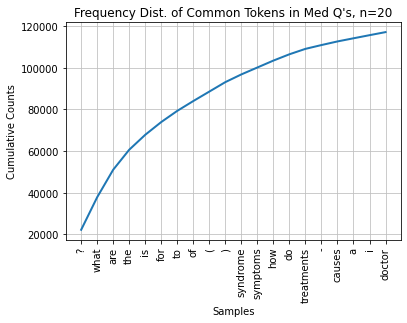

In [24]:
from nltk import FreqDist

questions_freq_dist = FreqDist(full_dataset)

questions_freq_dist.plot(20, cumulative=True, title="Frequency Dist. of Common Tokens in Med Q's, n=20")

In [25]:
print(f'There are {len(questions_freq_dist.hapaxes())} words that appear only once in the text.')
print('Some examples:')
questions_freq_dist.hapaxes()[:20]

There are 1786 words that appear only once in the text.
Some examples:


['ammonium',
 'lymphangiogram',
 'suprapubic',
 'beverages',
 'chia',
 'seeds',
 'among',
 'adolescents',
 'ppd',
 'piperonyl',
 'butoxide',
 'pyrethrins',
 'quit',
 'immunizations',
 'portals',
 'online',
 'tool',
 'rhinoplasty',
 'nursemaids',
 'carrying']

Now we can remove all the stop words we saw previously, and remove smaller words and punctuation to clean it further. However, since there are some small tokens we want to keep (specifically numbers designating the type of a disorder, i.e. `['type','1']`), we will also add a check in `remove_small_words` to keep tokens with a digit.

In [26]:
# Remove stopwords and punctuation
from nltk.corpus import stopwords

def remove_punctuation(corpus):
  punctuation = ".,\"-\\/#!?$%\^&\*;:{}=\-_'~()"
  filtered_corpus = [token for token in corpus if (not token in punctuation)]
  return filtered_corpus

def remove_stopwords(corpus):
  filtered_corpus = [token for token in corpus if (not token in stopwords.words('english'))]
  return filtered_corpus

def remove_small_words(corpus, min_len):
  filtered_corpus = [token for token in corpus if (len(token) > min_len) or any(i.isdigit() for i in token)]
  return filtered_corpus

def filter_tokens(corpus, min_word_len=3):
  return remove_punctuation(remove_stopwords(remove_small_words(corpus, min_word_len)))

In [27]:
full_dataset = filter_tokens(full_dataset)

questions_df['tokens'] = questions_df['tokens'].apply(filter_tokens)

In [28]:
full_dataset[:10]

['information',
 'refractive',
 'surgery',
 'doctor',
 'information',
 'ammonium',
 'hydroxide',
 'poisoning',
 'information',
 'lymphangiogram']

For good measure, let's do another frequency distribution analysis to see if this is what we expect.

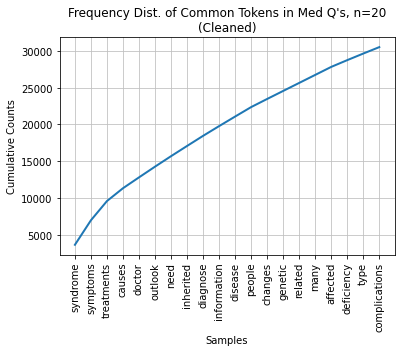

In [29]:
questions_freq_dist2 = FreqDist(full_dataset)

questions_freq_dist2.plot(20, cumulative=True, title="Frequency Dist. of Common Tokens in Med Q's, n=20\n(Cleaned)")

### N-Gram Analysis

We can try to find multi-word tokens (bi-gram, tri-gram,..., n-grams) that can be useful to us. Let's see what words are commonly used together.

In [30]:
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

bigram = nltk.collocations.BigramAssocMeasures()
trigram = nltk.collocations.TrigramAssocMeasures()

# Bigram analysis
print ('Finding frequent 2-grams')
q_bigram_finder = BigramCollocationFinder.from_words(full_dataset)
q_bigram_finder.apply_freq_filter(5)
bigram_tokens = q_bigram_finder.nbest(bigram.pmi, -1)
print(len(bigram_tokens), 'frequent 2-grams found.')
bigram_tokens

Finding frequent 2-grams
3889 frequent 2-grams found.


[('3-methylglutaconyl-coa', 'hydratase'),
 ('8p11', 'myeloproliferative'),
 ('activated', 'pi3k-delta'),
 ('adenine', 'phosphoribosyltransferase'),
 ('alpha-methylacyl-coa', 'racemase'),
 ('alternating', 'hemiplegia'),
 ('ankyloblepharon-ectodermal', 'defects-cleft'),
 ('aqueduct', 'sylvius'),
 ('assembly', 'enzyme'),
 ('behind', 'shoulders'),
 ('cholesteryl', 'ester'),
 ('collagen', 'vi-related'),
 ('corpus', 'callosum'),
 ('deafness-dystonia-optic', 'neuronopathy'),
 ('discoloration', 'bluish'),
 ('erythrokeratodermia', 'variabilis'),
 ('fiber-type', 'disproportion'),
 ('frequent', 'urgent'),
 ('gene', 'mutation'),
 ('hump', 'behind'),
 ('intercostal', 'retractions'),
 ('manitoba', 'oculotrichoanal'),
 ('mannose-binding', 'lectin'),
 ('mcleod', 'neuroacanthocytosis'),
 ('molybdenum', 'cofactor'),
 ('mthfr', 'gene'),
 ('mutated', 'cebpa'),
 ('mycosis', 'fungoides'),
 ('naegeli-franceschetti-jadassohn', 'syndrome/dermatopathia'),
 ('neuromyelitis', 'optica'),
 ('nucleoside', 'phosphory

We can see there are 3,889 frequent bigrams. Since there are some disorders or medical conditions that are 3 words, let's check for those too.

In [31]:
# Trigram analysis
q_trigram_finder = TrigramCollocationFinder.from_words(full_dataset)
q_trigram_finder.apply_freq_filter(5)
trigram_tokens = q_trigram_finder.nbest(TrigramAssocMeasures.pmi, -1)

print(len(trigram_tokens), 'frequent 3-grams found.')
trigram_tokens

1729 frequent 3-grams found.


[('behind', 'shoulders', 'dorsocervical'),
 ('hump', 'behind', 'shoulders'),
 ('mthfr', 'gene', 'mutation'),
 ('purine', 'nucleoside', 'phosphorylase'),
 ('north', 'american', 'indian'),
 ('ankyloblepharon-ectodermal', 'defects-cleft', 'lip/palate'),
 ('object', 'inhaled', 'swallowed'),
 ('osteolysis', 'nodulosis', 'arthropathy'),
 ('angioplasty', 'stent', 'placement'),
 ('medial', 'epicondylitis', 'golfer'),
 ('pinna', 'abnormalities', 'low-set'),
 ('lichenoides', 'varioliformis', 'acuta'),
 ('syndrome/toxic', 'epidermal', 'necrolysis'),
 ('abnormalities', 'low-set', 'ears'),
 ('cuts', 'puncture', 'wounds'),
 ('cluster', 'assembly', 'enzyme'),
 ('iron-sulfur', 'cluster', 'assembly'),
 ('erythrokeratodermia', 'variabilis', 'progressiva'),
 ('cytochrome', 'p450', 'oxidoreductase'),
 ('macroaneurysm', 'supravalvular', 'pulmonic'),
 ('frequent', 'urgent', 'urination'),
 ('pityriasis', 'rubra', 'pilaris'),
 ('coal', 'worker', 'pneumoconiosis'),
 ('arginine', 'glycine', 'amidinotransferase'

We also found 1,729 frequent trigrams. Let's add these to our dataframe. I created a function to go back through the tokens in the original dataframe and add these frequent ngrams where they appear.

In [32]:
def add_ngram_col(row, ngrams):
    # function to add ngrams to a new column in dataframe
    result = []
    if len(row['tokens']) >= len(ngrams[0]):
        token_string = '_'.join(row['tokens'])
        for ngram in ngrams:
            ngram_string = '_'.join(ngram)
            if ngram_string in token_string:
                result.append(ngram_string)
    return result
        

Here we have the `bigrams` column.

In [33]:
questions_df['bigrams'] = questions_df.apply(add_ngram_col, axis=1, args=(bigram_tokens,))
questions_df.loc[questions_df['bigrams'].str.len()!=0,('question','bigrams')].head(10)

,question,bigrams
3,Do you have information about Folic acid in diet,[folic_acid]
4,What is (are) Incontinentia pigmenti ?,[incontinentia_pigmenti]
5,What causes Incontinentia pigmenti ?,[incontinentia_pigmenti]
6,What are the symptoms of Incontinentia pigmenti ?,[incontinentia_pigmenti]
7,How to diagnose Incontinentia pigmenti ?,[incontinentia_pigmenti]
8,What are the treatments for Incontinentia pigm...,[incontinentia_pigmenti]
9,What is the outlook for Incontinentia pigmenti ?,[incontinentia_pigmenti]
10,Do I need to see a doctor for Incontinentia pi...,"[incontinentia_pigmenti, need_doctor]"
11,How to prevent Incontinentia pigmenti ?,[incontinentia_pigmenti]
12,What is (are) Mnire disease ?,[mnire_disease]


And here we have the `trigrams` column.

In [34]:
questions_df['trigrams'] = questions_df.apply(add_ngram_col, axis=1, args=(trigram_tokens,))
questions_df.loc[questions_df['trigrams'].str.len()!=0,('question','trigrams')].head(10)

,question,trigrams
20,What is (are) Coal worker's pneumoconiosis ?,[coal_worker_pneumoconiosis]
21,What causes Coal worker's pneumoconiosis ?,[coal_worker_pneumoconiosis]
22,What are the symptoms of Coal worker's pneumoc...,[coal_worker_pneumoconiosis]
23,How to diagnose Coal worker's pneumoconiosis ?,[coal_worker_pneumoconiosis]
24,What are the treatments for Coal worker's pneu...,[coal_worker_pneumoconiosis]
25,Where to find support for people with Coal wor...,"[coal_worker_pneumoconiosis, find_support_people]"
26,What is the outlook for Coal worker's pneumoco...,[coal_worker_pneumoconiosis]
27,What are the complications of Coal worker's pn...,[coal_worker_pneumoconiosis]
28,How to prevent Coal worker's pneumoconiosis ?,[coal_worker_pneumoconiosis]
29,What is (are) Ischemic ulcers - self-care ?,[ischemic_ulcers_self-care]


### Final Dataset

Our final dataset consists of 7 columns, `['question', 'question_type', 'focus', 'synonym', 'tokens', 'bigrams', 'trigrams']`. The `['tokens', 'bigrams', 'trigrams']` columns are generated, while the rest were in the original dataset. This sets us up for clustering analysis in the next section.

In [35]:
questions_df.head(20)

,question,question_type,focus,synonym,tokens,bigrams,trigrams
0,Do you have information about Refractive eye s...,information,Refractive eye surgery - what to ask your doctor,['What to ask your doctor about refractive eye...,"[information, refractive, surgery, doctor]",[],[]
1,Do you have information about Ammonium hydroxi...,information,Ammonium hydroxide poisoning,Aqueous - ammonia,"[information, ammonium, hydroxide, poisoning]",[],[]
2,Do you have information about Lymphangiogram,information,Lymphangiogram,"['Lymphography', 'Lymphangiography']","[information, lymphangiogram]",[],[]
3,Do you have information about Folic acid in diet,information,Folic acid in diet,"['Folic acid', 'Polyglutamyl folacin', 'Pteroy...","[information, folic, acid, diet]",[folic_acid],[]
4,What is (are) Incontinentia pigmenti ?,information,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[incontinentia, pigmenti]",[incontinentia_pigmenti],[]
5,What causes Incontinentia pigmenti ?,causes,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[causes, incontinentia, pigmenti]",[incontinentia_pigmenti],[]
6,What are the symptoms of Incontinentia pigmenti ?,symptoms,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[symptoms, incontinentia, pigmenti]",[incontinentia_pigmenti],[]
7,How to diagnose Incontinentia pigmenti ?,exams and tests,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[diagnose, incontinentia, pigmenti]",[incontinentia_pigmenti],[]
8,What are the treatments for Incontinentia pigm...,treatment,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[treatments, incontinentia, pigmenti]",[incontinentia_pigmenti],[]
9,What is the outlook for Incontinentia pigmenti ?,outlook,Incontinentia pigmenti,Bloch-Sulzberger syndrome,"[outlook, incontinentia, pigmenti]",[incontinentia_pigmenti],[]


In [36]:
questions_df.to_csv('./data/final_tokenized_questions.csv', index=False)

Submission must include:
1. The powerpoint
2. All code, scripts, and commands
3. The initial dataset and the cleaned dataset

All of these must be in a single zip file uploaded to canvas no later than April 4th 11:59pm.